Helper Function to retrieve stock data 


In [86]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import sqlite3
# This works on a windows machine. I have no idea if it will work on linux
# gets stock data using the yfinance api
def getStockData(tag,period,interval):
    # gets the current date
    todaysDate = datetime.today()
    formattedDate = todaysDate.strftime('%y%m%d')

    # creates a datafolder that stores some data so fewer calls are made to the yfinance api
    folder_path = os.path.join('datafolder', formattedDate)
    os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, tag + period + interval + formattedDate +'.txt')
    if os.path.exists(file_path):
        # retrieves stock data from the files
        with open(file_path, 'r') as file:
            stockData = [float(line.strip()) for line in file]
    else:
        # retrieves the stock data from the api
        ticker = yf.Ticker(tag)
        stockData = ticker.history(period, interval)["Close"]
        with open(file_path, 'w') as file:
            for item in stockData:
                file.write(f"{item}\n")
    
    return stockData


Helper Functions

In [88]:
# zscoreMaxNormalization
def zscoreNormalization(data):
    mean = np.mean(data)
    std = np.std(data)
    normalizedData = (data-mean)/(std)
    return normalizedData
# retrives correlation data from the database
def retrieveCorrelationData(tag):
    database = sqlite3.connect("processdDB.db")
    cursor = database.cursor()
    cursor.execute("SELECT DISTINCT " + tag +  " FROM CrossCorrelationResults")
    correlationData = cursor.fetchall()
    database.close()
    return correlationData

# returns volatility data in a dictionary for either monthly or yearly or both for a certain period
def retrieveVolatilityData(tags, period,monthlyOrYearly):
    database = sqlite3.connect("processdDB.db")
    cursor = database.cursor()
    cursor.execute("SELECT DISTINCT * FROM Volatility WHERE period = ? " , (period,))
    volatilityData = cursor.fetchall()
    database.close()
    returnVolatilityData = {}
    monthlyVolatility = {}
    yearlyVolatility = {}
    # takes the raw data from the database and converts it into two dictionaries of tag, volatility
    for tag in tags:
        if monthlyOrYearly.lower() == "monthly" or monthlyOrYearly.lower() == "both":
            for value in volatilityData:
                if value[0] == tag:
                    monthlyVolatility[tag] = value[1]
        if monthlyOrYearly.lower() == "yearly" or monthlyOrYearly.lower() == "both":
            for value in volatilityData:
                if value[0] == tag:
                    yearlyVolatility[tag] = value[2]
    # combines the two dictionaries into one.
    returnVolatilityData["monthly"] = monthlyVolatility
    returnVolatilityData["yearly"] = yearlyVolatility
    return returnVolatilityData

# gets the mean of the all the correlation data stored in the database using the numpy library
def getCorrelationMean():
    data = retrieveCorrelationData("max_correlation")
    mean = np.mean(data)
    return mean

# gets the standard deviation of the all the correlation data stored in the database using the numpy library
def getCorrelationStd():
    data = retrieveCorrelationData("max_correlation")
    std = np.std(data)
    return std

# gets all the quartiles and median of the all the correlation data stored in the database using the numpy library
def getQuartiles():
    data = retrieveCorrelationData("max_correlation")
    q1 = np.quantile(data, 0.25)
    median = np.quantile(data, 0.5)
    q3 = np.quantile(data, 0.75)
    return (q1,median,q3)

# converts the input data to percentage
def convertToPercentageData(data):
    return np.diff(data) / data[:-1] * 100

# computes the standard deviation of the monthly data
def computeMonthlyVolatility(tag,period,interval):
    data = getStockData(tag,period,interval)
    percentageData = convertToPercentageData(data)
    monthlyVolatility = np.std(percentageData)
    return monthlyVolatility

# takes the standard deviation of the monthly data and multiplies it by the square root of 12 to get yearly
def computeYearlyVolatility(tag,period,interval):
    monthlyVolatility = computeMonthlyVolatility(tag,period,interval)
    return monthlyVolatility * np.sqrt(12)

# returns all the months in in a defined period in an array
def getAllMonthsInPeriod(periodYear,currentYear,currentMonth):
    months = [
                "January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"
            ]
    dates = []
    total_months = int(periodYear) * 12
    for i in range(total_months):
        year = currentYear - ((i + (12 - currentMonth))// 12)
        month_index = (currentMonth - 1 - i) % 12
        month_name = months[month_index]
        dates.append(f"{month_name} {year}")
    return dates[::-1]

Saving to database

In [89]:
# Saves the max correlation and lag data for the defined tags to the database
def saveCorrelationToDatabase(tag1,tag2,correlationData):
    database = sqlite3.connect("processdDB.db")
    cursor = database.cursor()
# creates a tuple of the tags     
    tags = [tag1,tag2]
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS CrossCorrelationResults (
            tag1 TEXT NOT NULL,
            tag2 TEXT NOT NULL,
            max_correlation REAL NOT NULL,
            max_lag INTEGER NOT NULL,
            avg_correlation REAL NOT NULL,
            period STRING NOT NULL,
            description STRING NOT NULL,
            UNIQUE(tag1, tag2,period)
    )
    """)
#     retrieves max correlation and maxlag from the passed in data.
    maxCorr = correlationData["maxCorr"]
    maxLag = int(correlationData["maxLag"])
    avgCorrelation = correlationData["averageCorrelation"]
    period = correlationData["period"]
#     writes the descriptions that are put into the database
    if maxLag > 0:
        firstDescription = tag1 + " leads " + tag2 +" by " + str(maxLag) + " months."
        secondDescription = tag2 + " lags behind " + tag1 +" by " + str(maxLag) + " months."
    elif maxLag == 0:
        firstDescription = tag1 + " does not lag behind " + tag2 + " at all."
        secondDescription = tag2 + " does not lag behind " + tag1 + " at all."
    else:
        firstDescription = tag2 + " leads " + tag1 + " by " + str(maxLag*-1) + " months."
        secondDescription = tag1 + " lags behind " + tag2 + " by " + str(maxLag*-1) + " months."
# puts the entries in twice in order to have company one as tag1 and tag2 in the database.
    cursor.execute("""
            REPLACE INTO CrossCorrelationResults (tag1, tag2, max_correlation, max_lag, avg_correlation, period, description)
            VALUES (?, ?, ?, ?,?,?,?)
            """, (tags[0], tags[1], maxCorr, maxLag,avgCorrelation,period,firstDescription))
    cursor.execute("""
            REPLACE INTO CrossCorrelationResults (tag1, tag2, max_correlation, max_lag, avg_correlation, period, description)
            VALUES (?, ?, ?, ?,?,?,?)
            """, (tags[1], tags[0], maxCorr, maxLag*-1,avgCorrelation,period,secondDescription))
    database.commit()
    database.close()

# saves the monthly and yearly volatility for the period to the database
def saveVolatilityToDatabase(tag,monthlyVolatility,yearlyVolatility, period, dateStored):
    database = sqlite3.connect("processdDB.db")
    cursor = database.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Volatility (
            tag TEXT NOT NULL,
            monthlyVolatility REAL NOT NULL,
            yearlyVolatility REAL NOT NULL,
            period STRING NOT NULL,
            dateStored STRING NOT NULL,
            UNIQUE(tag,period)
    )
    """)
    cursor.execute("""
            REPLACE INTO Volatility (tag, monthlyVolatility, yearlyVolatility, period, dateStored)
            VALUES (?, ?, ?, ?, ?)
            """, (tag, monthlyVolatility, yearlyVolatility, period, dateStored))
    
    database.commit()
    database.close()

Volatility Chart Creater

In [90]:
def createVolatilityBarChart(tickers,period,monthlyOrYearly):
    volatilityData = retrieveVolatilityData(tickers, period,monthlyOrYearly)
    # Seperates the monthly and yearly data
    monthlyVolatilityData = volatilityData["monthly"]
    yearlyVolatilityData = volatilityData["yearly"]
    # checking if empty
    if len(monthlyVolatilityData) != 0:
        # sorts the monthly data alphabetically
        monthlyVolatilityData = dict(sorted(monthlyVolatilityData.items(), key=lambda item: item[1]))
        # gets an array of only the tags
        tags = [key for key, value in monthlyVolatilityData.items() if value]
        # gets an array of only the values
        values = [monthlyVolatilityData[tag] for tag in tags]
        # makes a bar chart of the data
        plt.figure(figsize=(14, 6))
        plt.bar(tags, values, color='skyblue')
        plt.title("Monthly Volatility")
        plt.xlabel("Tags")
        plt.ylabel("Volatility \n (In Percentage Change)")
        plt.grid()
        plt.tight_layout()
        plt.show()
    if len(yearlyVolatilityData) != 0:
        # sorts the monthly data alphabetically
        yearlyVolatilityData = dict(sorted(yearlyVolatilityData.items(), key=lambda item: item[1]))
        # gets an array of only the tags
        tags = [key for key, value in yearlyVolatilityData.items() if value]
        # gets an array of only the values
        values = [yearlyVolatilityData[tag] for tag in tags]
        # makes a bar chart of the data
        plt.figure(figsize=(14, 6))
        plt.bar(tags, values, color='skyblue')
        plt.title("Yearly Volatility")
        plt.xlabel("Tags")
        plt.ylabel("Volatility \n (In Percentage Change)")
        plt.grid()
        plt.tight_layout()
        plt.show()

Cross Correlation Analysis

In [91]:
def crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph,period = "1y"):
    
    # period = "5y"
    interval = "1mo"
    data = getStockData(tag1,period,interval)
    data2 = getStockData(tag2,period,interval)
    
    percentageChange = convertToPercentageData(data)
    percentageChange2 = convertToPercentageData(data2)
    

    # makes sure that the data was returned correctly and then does the cross correlation on them.
    if len(percentageChange) ==len(percentageChange2):
        if printInfo:
            print(percentageChange)
            print(percentageChange2)

        # makes an array that is the length
        lagValues = np.arange(-len(percentageChange2) + 1, len(percentageChange))
        crossCorr = np.correlate(percentageChange, percentageChange2, "Full")
        
        # normalizes the values in the cross correlation
        normalizedCrossCorrelation = zscoreNormalization(crossCorr)
       
        # finds the max correlation value
        maxCorr = normalizedCrossCorrelation.max()
        # finds the lag of the max correlation value.
        maxLag = lagValues[np.argmax(normalizedCrossCorrelation)]
        n = int(np.ceil(len(normalizedCrossCorrelation)/4))
        topNLargestValues = np.sort(normalizedCrossCorrelation)[-n:]
        averageCorrelation = np.mean(topNLargestValues)
        if printInfo:
            print(f"Max Cross-Correlation: {maxCorr} at Lag: { maxLag}")
            for lag, corr in zip(lagValues, normalizedCrossCorrelation):
                print(f"Lag: {lag}, Cross-correlation: {corr}")
        # creates the cross correlation graph for the two companies
        if displayLagGraph:
            if maxLag > 0:
                Description = tag1 + " leads " + tag2 +" by " + str(maxLag) + " months."
            elif maxLag == 0:
                Description = tag1 + " does not lag behind " + tag2 + " at all."
            else:
                Description = tag2 + " leads " + tag1 + " by " + str(maxLag*-1) + " months."
            plt.figure(figsize=(10, 6))
            plt.plot(lagValues, normalizedCrossCorrelation, marker='o')
            plt.axvline(maxLag, color='red', linestyle='--', label="Max Correlation Lag")
            plt.title(f"Cross-Correlation between {tag1} and {tag2} \n "+ Description)
            plt.xlabel("Lag (Months)")
            plt.ylabel("Correlation Coefficient")
            plt.legend()
            plt.grid()
            plt.show()
        # overlays the two companies stock data over one another counting for the lag value
        if displayStockGraph:
            todaysDate = datetime.today()
            currentMonth = todaysDate.month
            currentYear = todaysDate.year
            
            periodYear = period[0]
           
            dates = getAllMonthsInPeriod(periodYear,currentYear,currentMonth)
            if maxLag > 0:
                Description = tag1 + " leads " + tag2 +" by " + str(maxLag) + " months."
                percentageChange= percentageChange[:-maxLag]
                percentageChange2 = percentageChange2[maxLag:]
                dates = dates[maxLag+1:]
                legendHelperTag1 = tag1 +" + "+ str(maxLag)
                legendHelperTag2 = tag2 
                
            elif maxLag == 0:
                Description = tag1 + " does not lag behind " + tag2 + " at all."
                legendHelperTag1 = tag1 +" + "+ str(maxLag)
                legendHelperTag2 = tag2 + " + " + str(maxLag)
                dates = dates[1:]
            else:
                Description = tag2 + " leads " + tag1 + " by " + str(maxLag*-1) + " months."
                percentageChange = percentageChange[-maxLag:]
                percentageChange2 = percentageChange2[:+maxLag]
                dates = dates[-maxLag+1:]
                legendHelperTag1 = tag1 
                legendHelperTag2 = tag2 + " + " + str(-maxLag)
            
            
            if periodYear == "1":
                plt.figure(figsize=(14, 6))
            else:
                plt.figure(figsize=(90, 15))
            plt.plot(dates, percentageChange, marker='o',label= legendHelperTag1)
            plt.plot(dates, percentageChange2, marker='o',label = legendHelperTag2)
            plt.title(f"Percentage Change In Stock Price For {tag1} and {tag2} After Applying The Lag" + "\n" + Description)
            plt.xlabel("Months")
            plt.ylabel("Percentage Change")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()
        if shouldSaveToDatabase:
            correlationData = {}
            correlationData["maxCorr"] = maxCorr
            correlationData["maxLag"] = maxLag
            correlationData["averageCorrelation"] = averageCorrelation
            correlationData["period"] = period
            saveCorrelationToDatabase(tag1,tag2,correlationData)
    # only runs when yfinance messes up
    else:
        print("We got bad data on the correlation between" + tag1 + " and " + tag2)




Bulk Helper Functions for finding volatility and correlating the data while also saving it to the database

In [92]:
def findVolatilityAndSaveAll(allTickers,includeFiveYear):
    tickers = allTickers
    period = "1y"
    periods = []
    periods.append(period)
    if includeFiveYear:
        periods.append("5y")
    interval = "1mo"
    todaysDate = datetime.today()
    todaysDate = todaysDate.strftime('%Y-%m-%d')
    for period in periods:
        for ticker in tickers:
            monthlyVolatility = computeMonthlyVolatility(ticker,period,interval)
            yearlyVolatility = computeYearlyVolatility(ticker,period,interval)
            saveVolatilityToDatabase(ticker,monthlyVolatility,yearlyVolatility, period,todaysDate)

def correlateAndSaveAll(allTickers):
    tickers = allTickers
    periods = ["1y","5y"]
    while len(tickers) > 1:
        currentTicker = tickers.pop(0)
        for eachTicker in tickers:
            for period in periods:
                crossCorrelation(currentTicker,eachTicker,False,False,True,False,period)

Produces graphs to better understand the cross correlation data

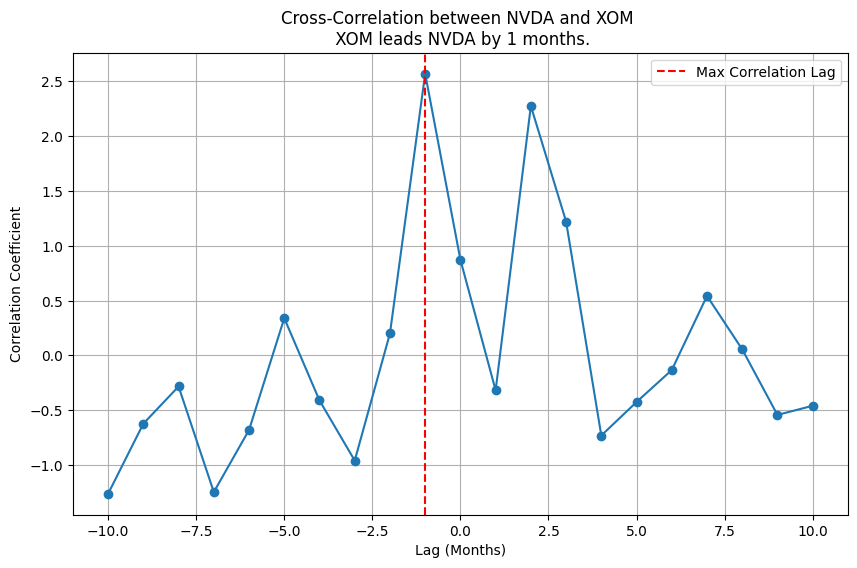

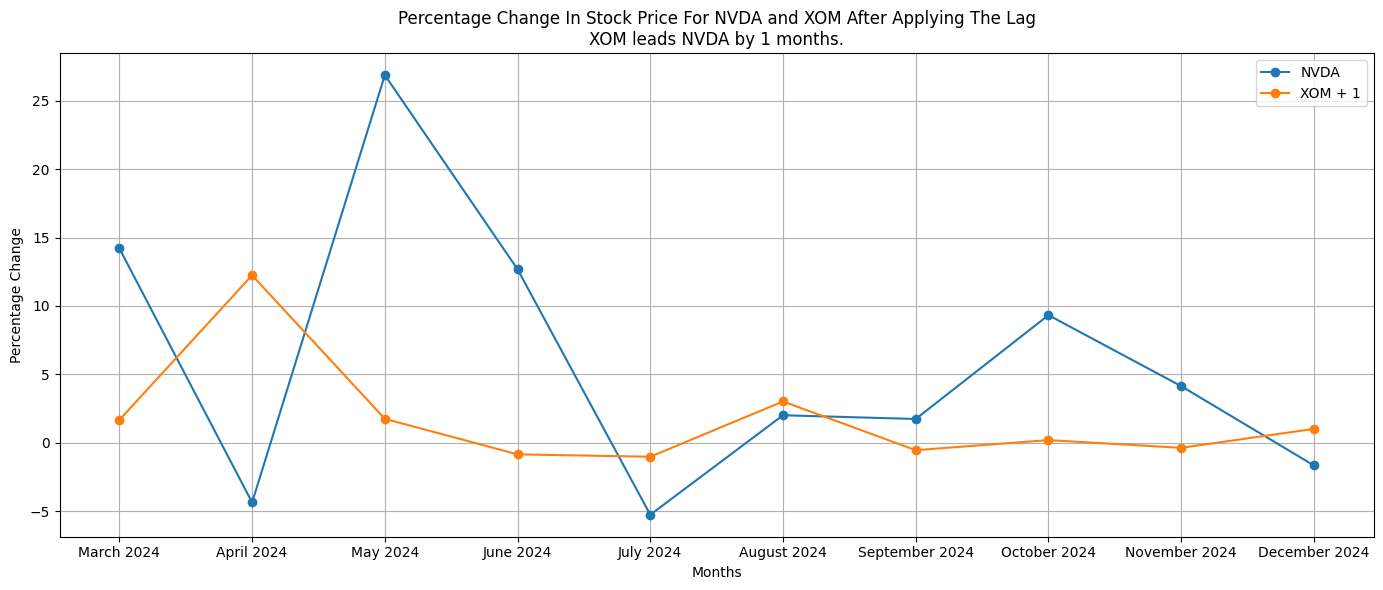

In [93]:
tag1 = "NVDA"
# tag1 = "CSCO"
# tag2 = "ADP"
tag2 = "XOM"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

Calls the helper functions to find and save the cross correlation for all the listed tags

In [94]:
tech_tickers = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet (Google)
    "AMZN",  # Amazon
    "TSLA",  # Tesla
    "NVDA",  # NVIDIA
    "META",  # Meta Platforms (Facebook)
    "INTC",  # Intel
    "AMD",   # Advanced Micro Devices
    "CSCO",  # Cisco Systems
    "TSM",   # TSMC
    "ADP",   # Automatic Data Processing
    "UBER",  # Uber
    "AMC",   # American Movie Classics
    "XOM",   # Exxon
    "KO",    # Coca-Cola
    "JNJ",   # Johnson & Johnson
    "WMT",   # Walmart
    "V",     # Visa
    "NKE",   # Nike
    "NFLX",  # Netflix
    "PG",    # Procter & Gamble
    "GE",    # General Electric
    "PEP",   # PepsiCo
    "MCD",   # McDonald's
]
# just pass in tickers as show here
correlateAndSaveAll(tech_tickers)


Calls the helper functions to find and save the volatility for all the listed tags

In [95]:
tech_tickers = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet (Google)
    "AMZN",  # Amazon
    "TSLA",  # Tesla
    "NVDA",  # NVIDIA
    "META",  # Meta Platforms (Facebook)
    "INTC",  # Intel
    "AMD",   # Advanced Micro Devices
    "CSCO",  # Cisco Systems
    "TSM",   # TSMC
    "ADP",   # Automatic Data Processing
    "UBER",  # Uber
    "AMC",   # American Movie Classics
    "XOM",   # Exxon
    "KO",    # Coca-Cola
    "JNJ",   # Johnson & Johnson
    "WMT",   # Walmart
    "V",     # Visa
    "NKE",   # Nike
    "NFLX",  # Netflix
    "PG",    # Procter & Gamble
    "GE",    # General Electric
    "PEP",   # PepsiCo
    "MCD",   # McDonald's
]
# just pass in tickers and whether to calculate for a five year period as well as a one year period as show here
includeFiveYear = True
findVolatilityAndSaveAll(tech_tickers,includeFiveYear)

Uses the data gathered from the database to find some significant statistical measures like mean, std, etc..

In [96]:
period = "1y"
interval = "1mo"
tag = "NVDA"
print("Mean Of all of the Correlations is " + str(getCorrelationMean()))
print("Standard Deviation of all the Correlations is " + str(getCorrelationStd()))
quartiles = getQuartiles()
print("The first quartile of all the Correlations is " + str(quartiles[0]) + " and the median is "+ str(quartiles[1])+ " and the third quartile is "+str(quartiles[2]))
print("Monthly Volatilty of " + tag +" for the last year is " + str(computeMonthlyVolatility(tag,period,interval)))
print("Yearly Volatilty of " + tag + " for the last year is " + str(computeYearlyVolatility("NVDA",period,interval)))


Mean Of all of the Correlations is 3.032153319759476
Standard Deviation of all the Correlations is 1.1110028551695916
The first quartile of all the Correlations is 2.171114994181135 and the median is 2.844794888412764 and the third quartile is 3.637664305133733
Monthly Volatilty of NVDA for the last year is 11.09975000564067
Yearly Volatilty of NVDA for the last year is 38.450661922165146


Graph For Volatility

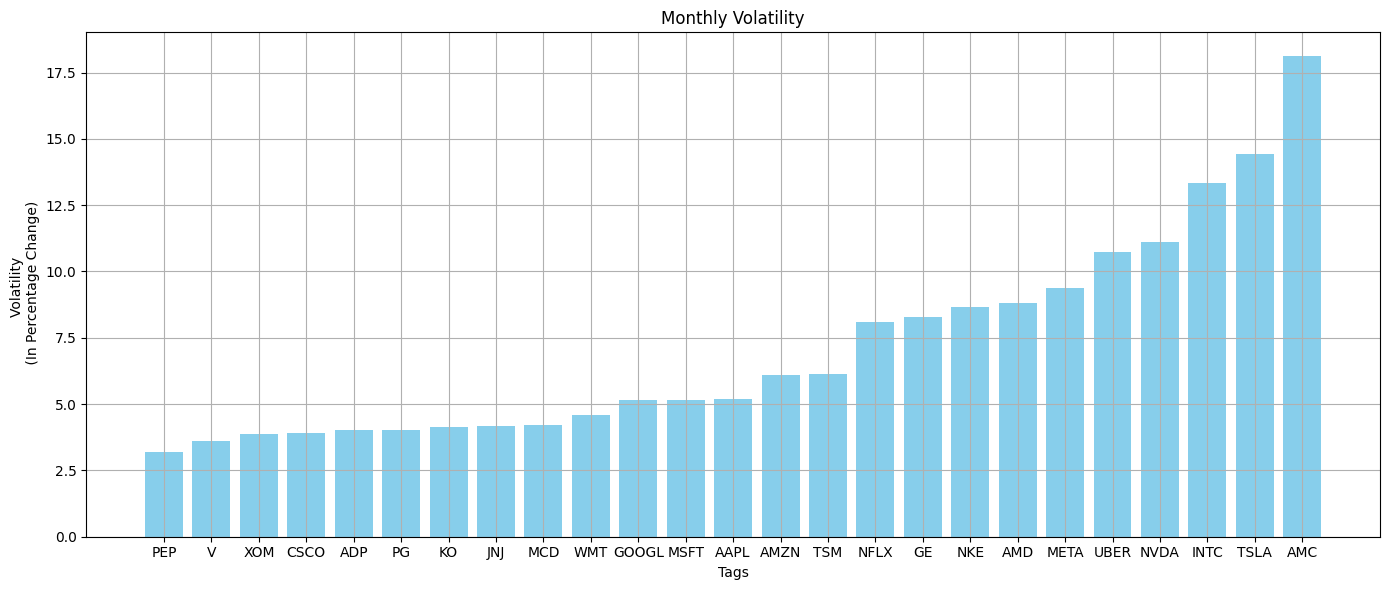

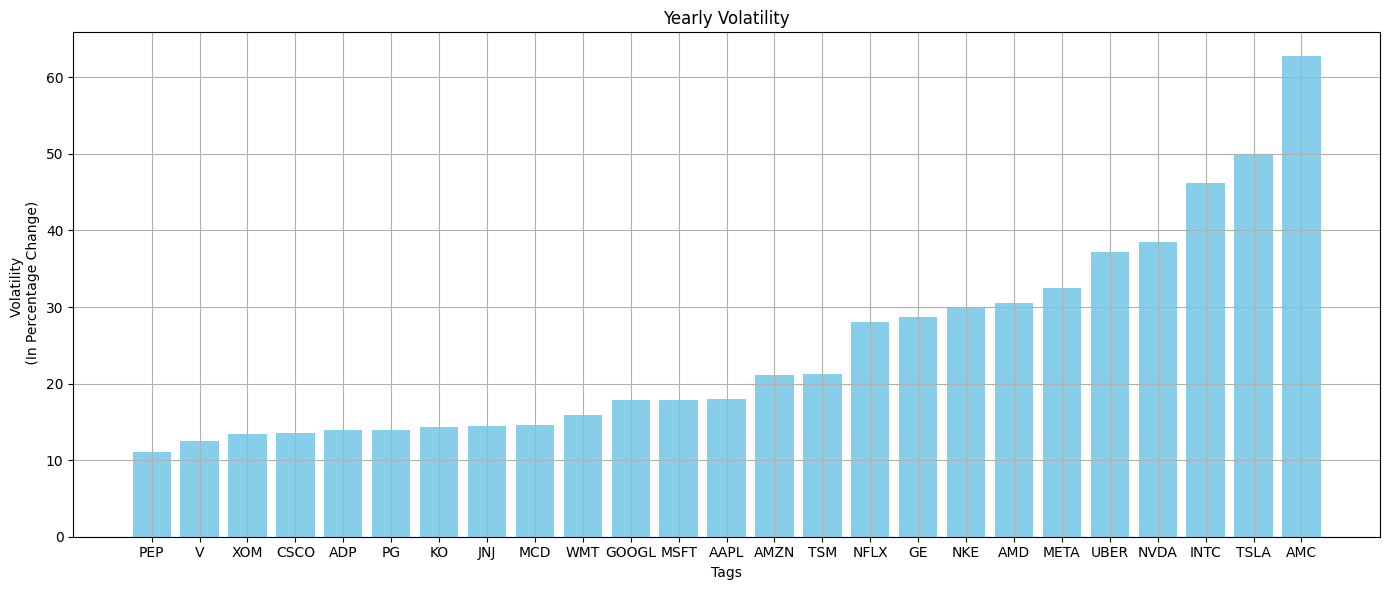

In [97]:
tech_tickers = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet (Google)
    "AMZN",  # Amazon
    "TSLA",  # Tesla
    "NVDA",  # NVIDIA
    "META",  # Meta Platforms (Facebook)
    "INTC",  # Intel
    "AMD",   # Advanced Micro Devices
    "CSCO",  # Cisco Systems
    "TSM",   # TSMC
    "ADP",   # Automatic Data Processing
    "UBER",  # Uber
    "AMC",   # American Movie Classics
    "XOM",   # Exxon
    "KO",    # Coca-Cola
    "JNJ",   # Johnson & Johnson
    "WMT",   # Walmart
    "V",     # Visa
    "NKE",   # Nike
    "NFLX",  # Netflix
    "PG",    # Procter & Gamble
    "GE",    # General Electric
    "PEP",   # PepsiCo
    "MCD",   # McDonald's
]
# pass in tickers, whether it should create a graph for the monthly or yearly data or both and for what period
monthlyOrYearly = "both" # Can be "monthly" or "yearly" or both. It is not case sensitive
period = "1y" #"1y" or "5y"
createVolatilityBarChart(tech_tickers,period,monthlyOrYearly)

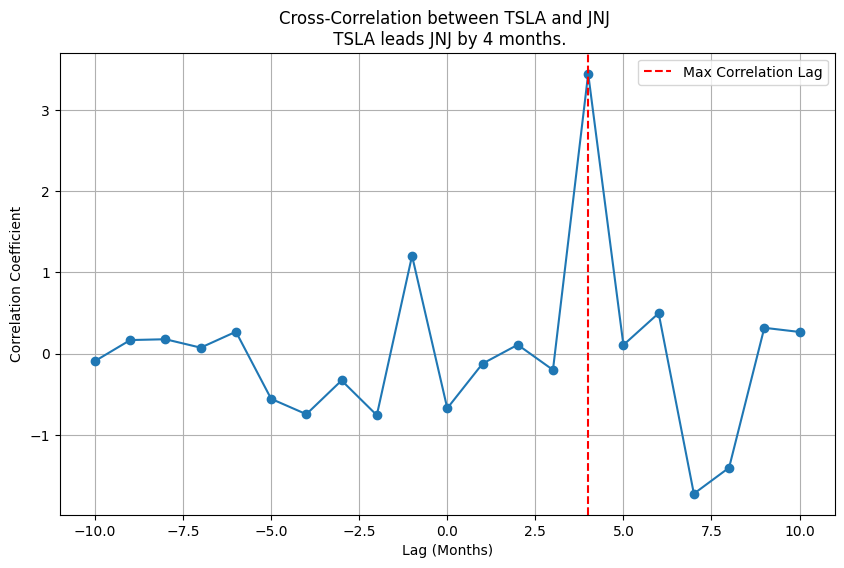

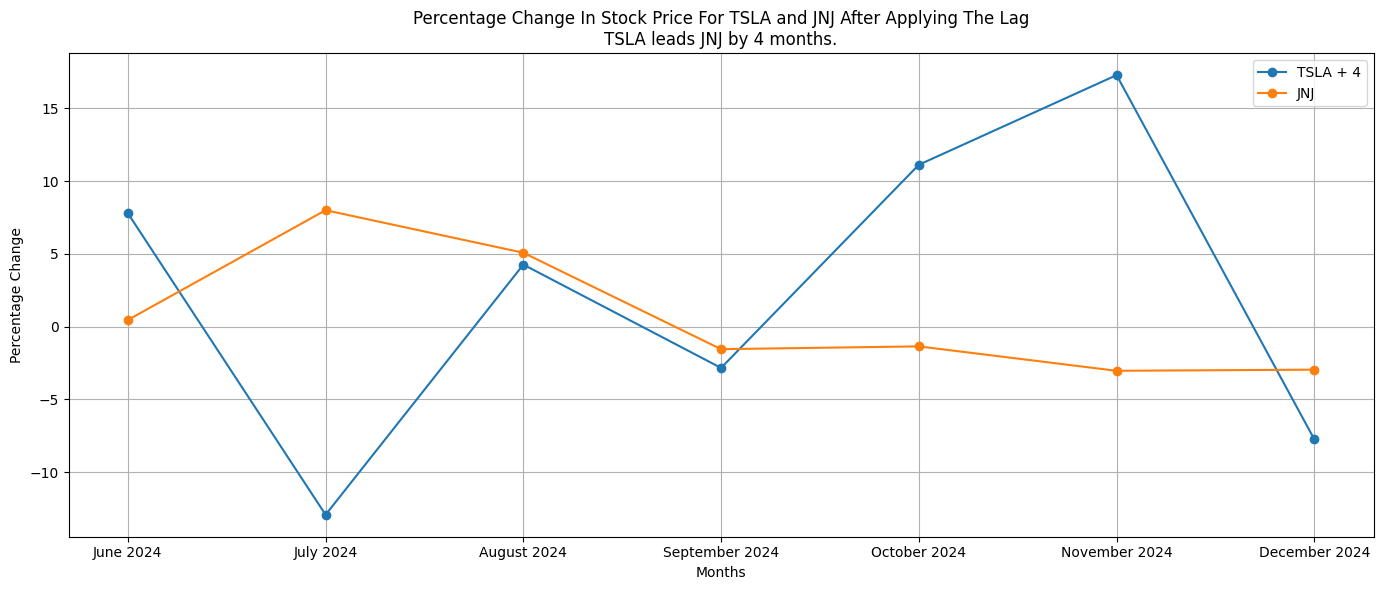

In [98]:
tag1 = "TSLA"
tag2 = "JNJ"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

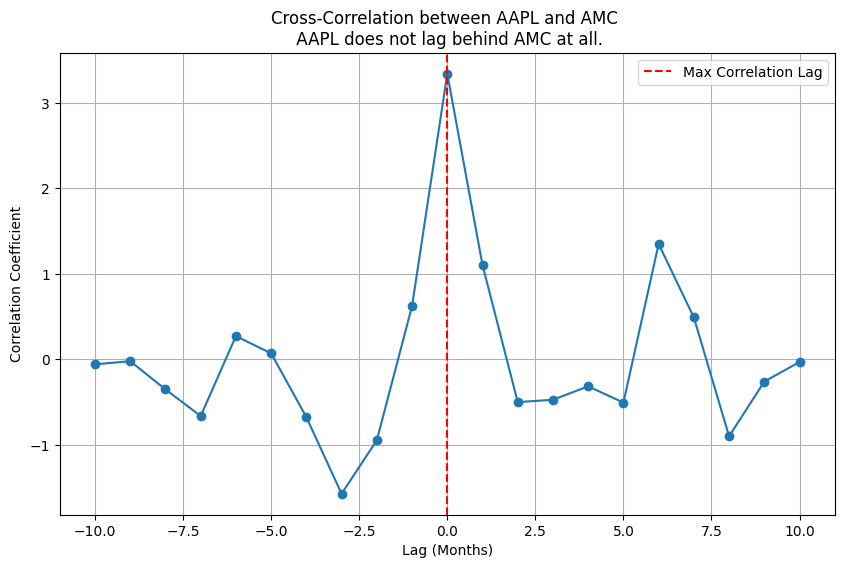

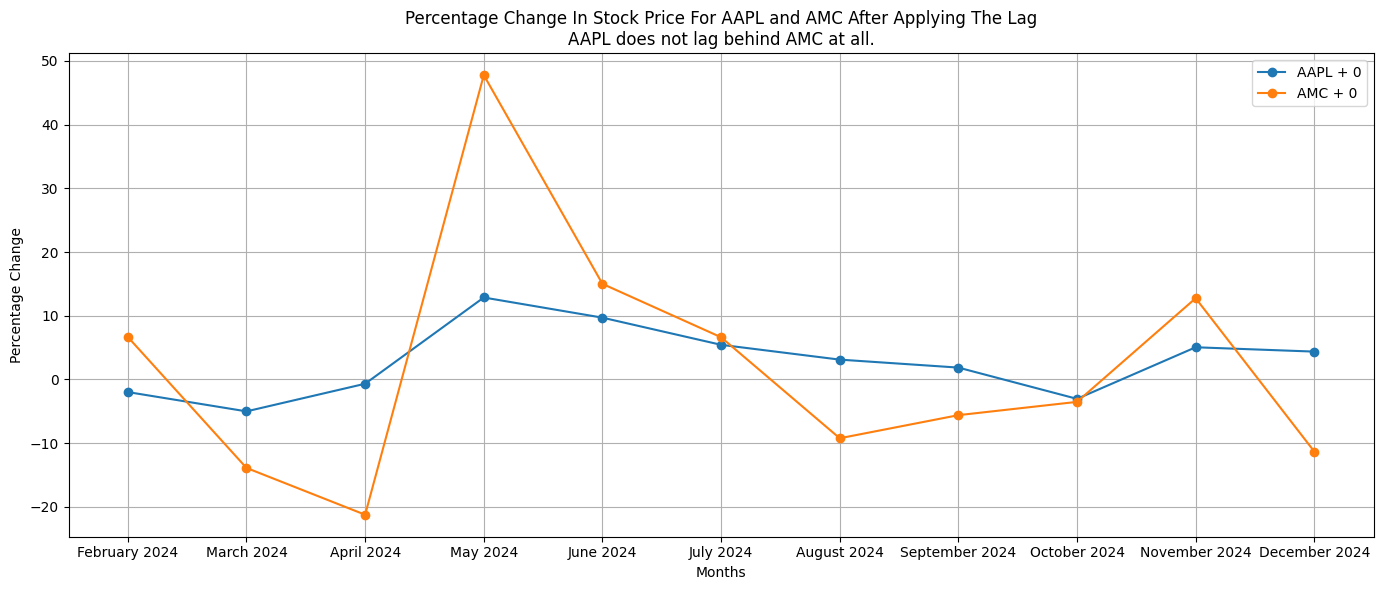

In [99]:
tag1 = "AAPL"
tag2 = "AMC"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

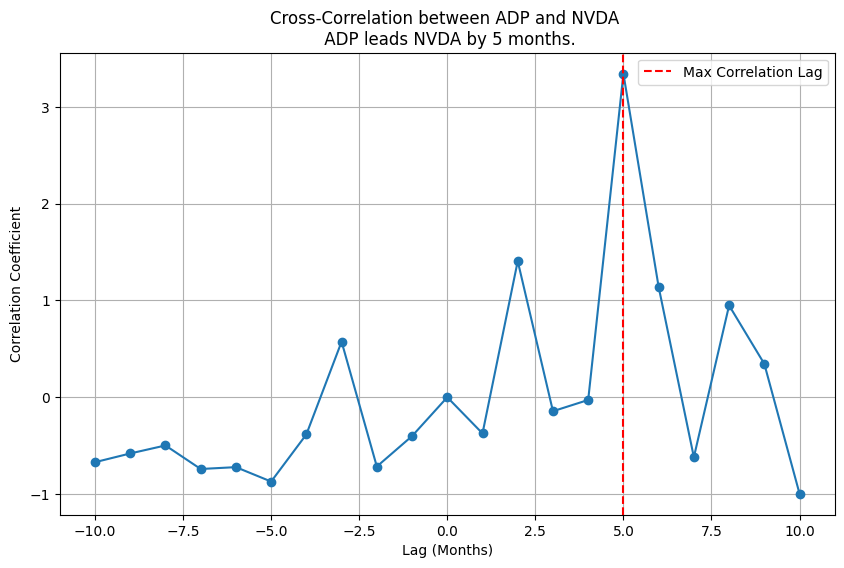

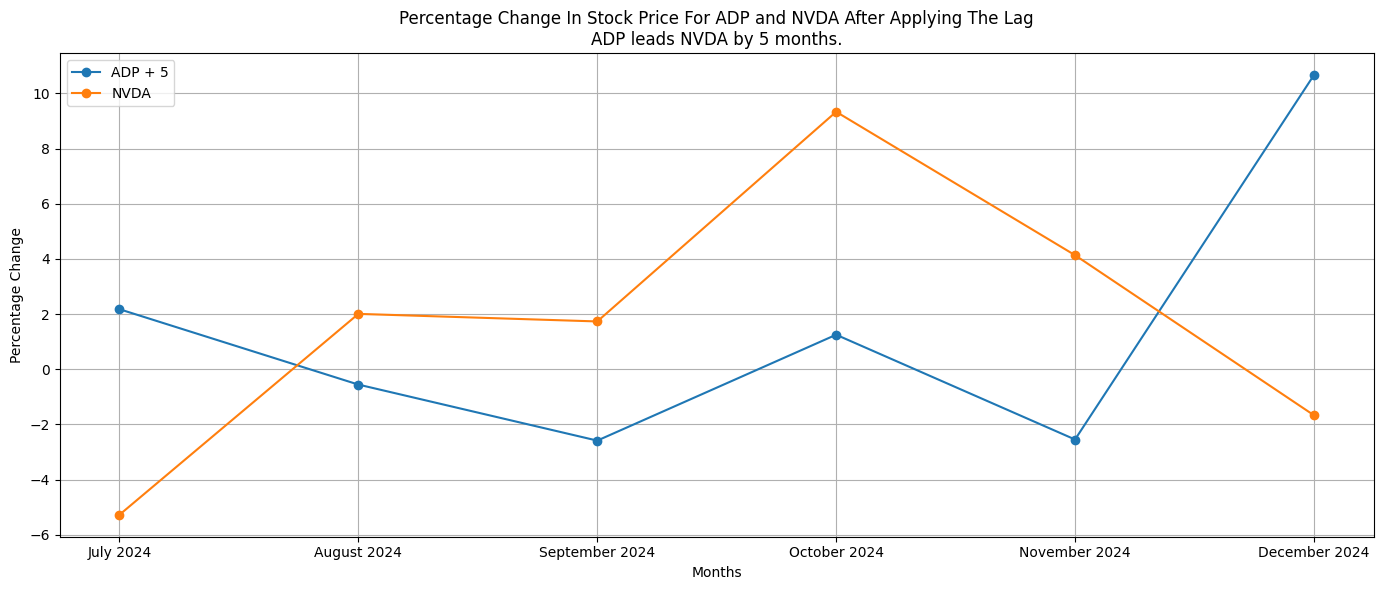

In [100]:
tag1 = "ADP"
tag2 = "NVDA"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

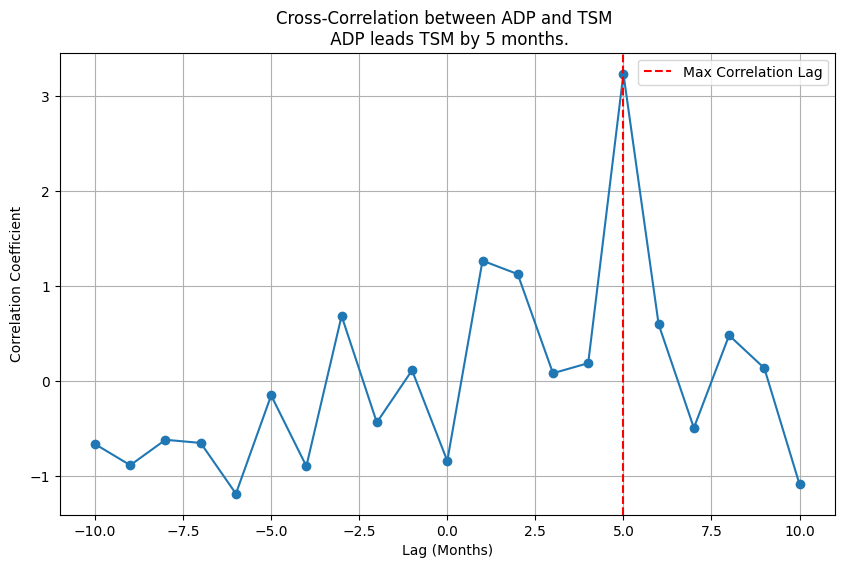

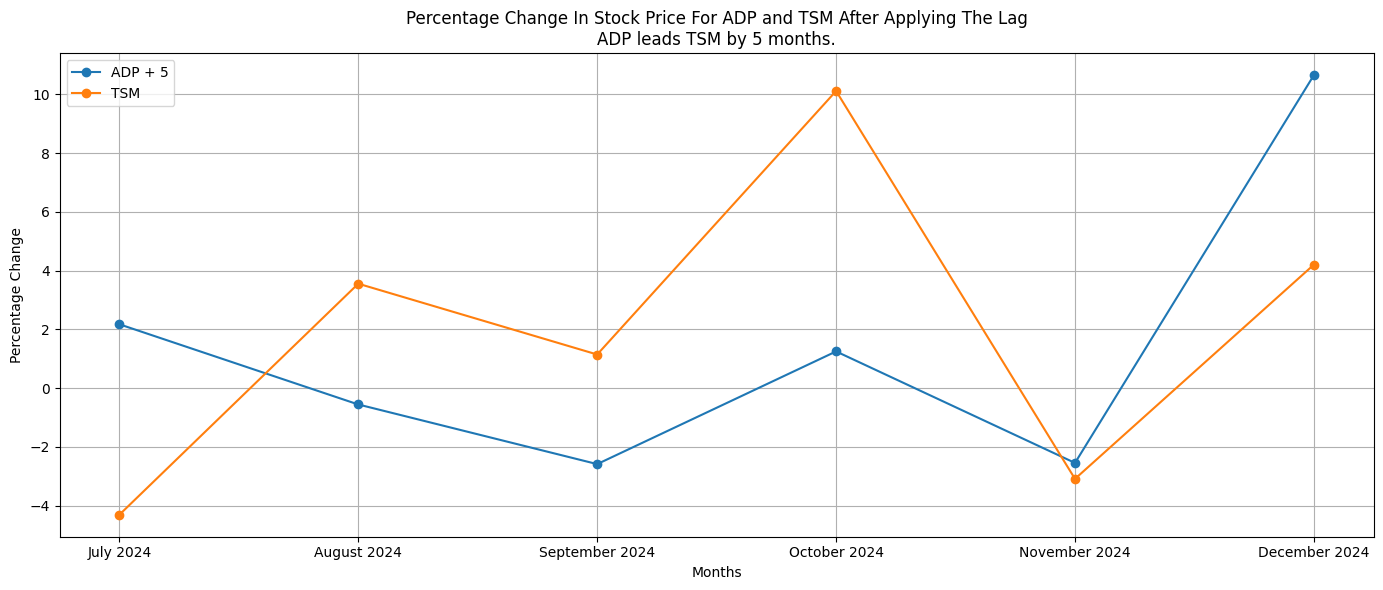

In [101]:
tag1 = "ADP"
tag2 = "TSM"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

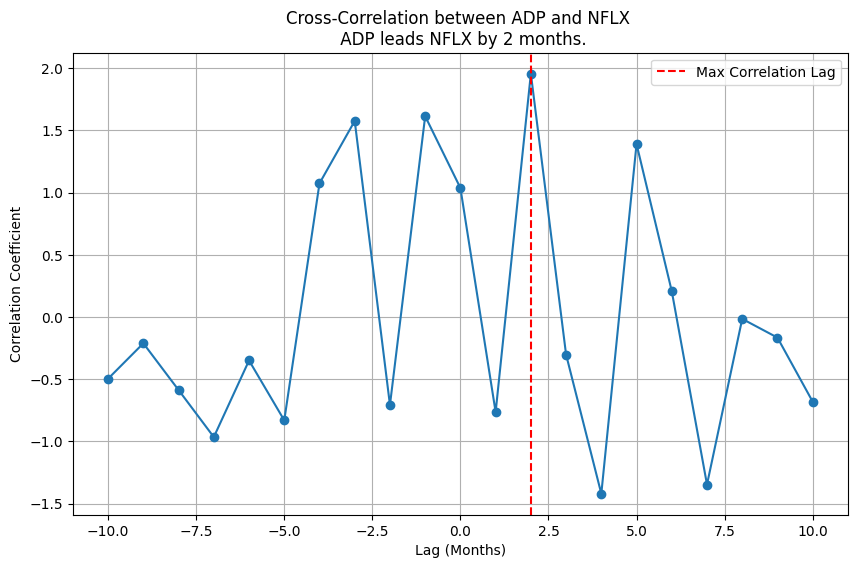

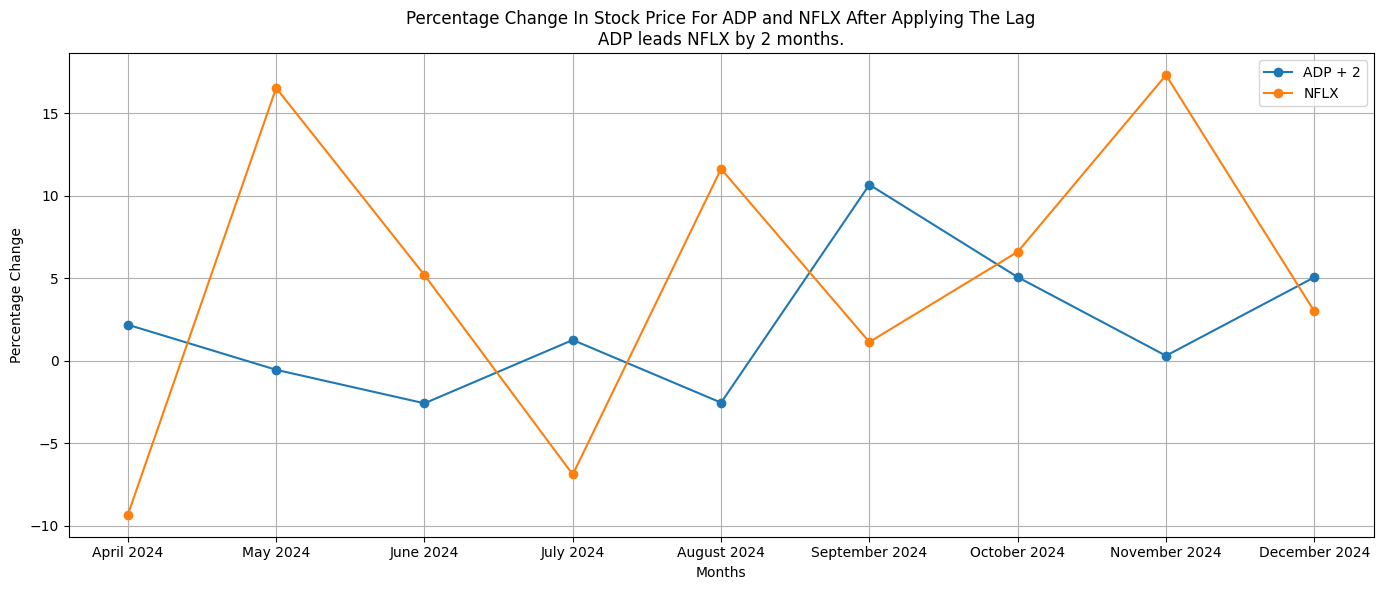

In [102]:
tag1 = "ADP"
tag2 = "NFLX"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

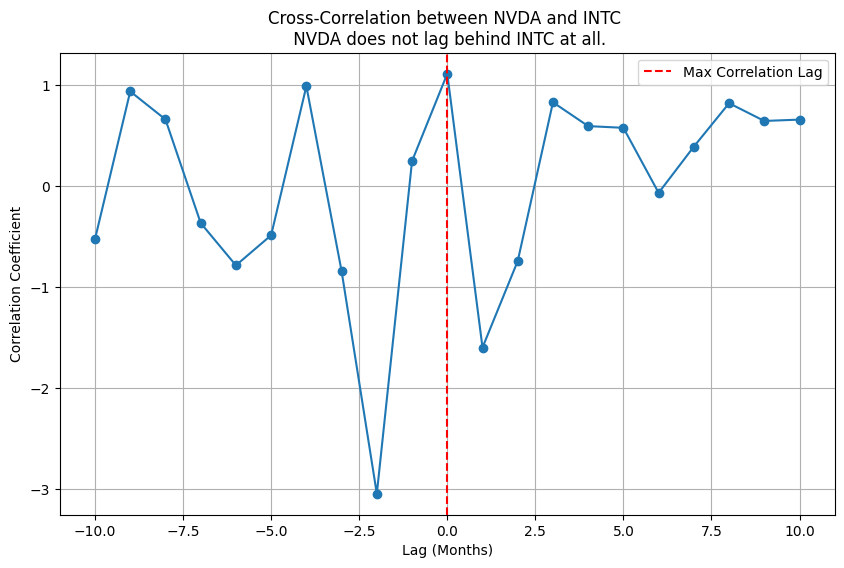

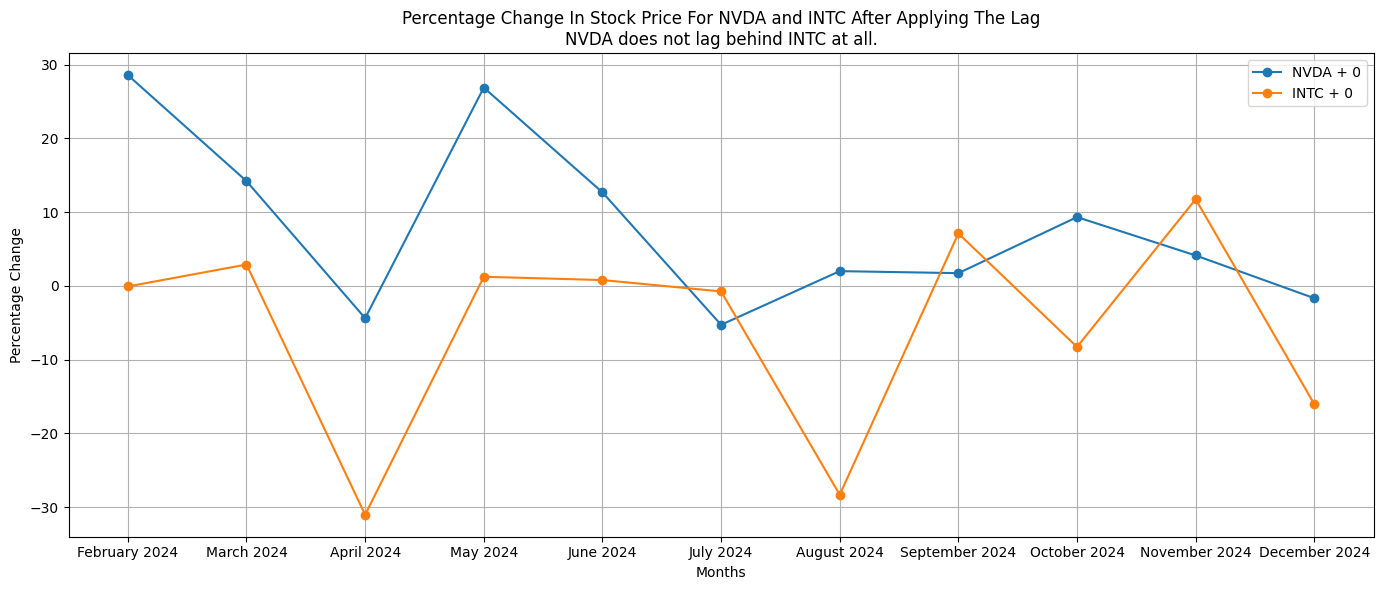

In [103]:
tag1 = "NVDA"
tag2 = "INTC"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

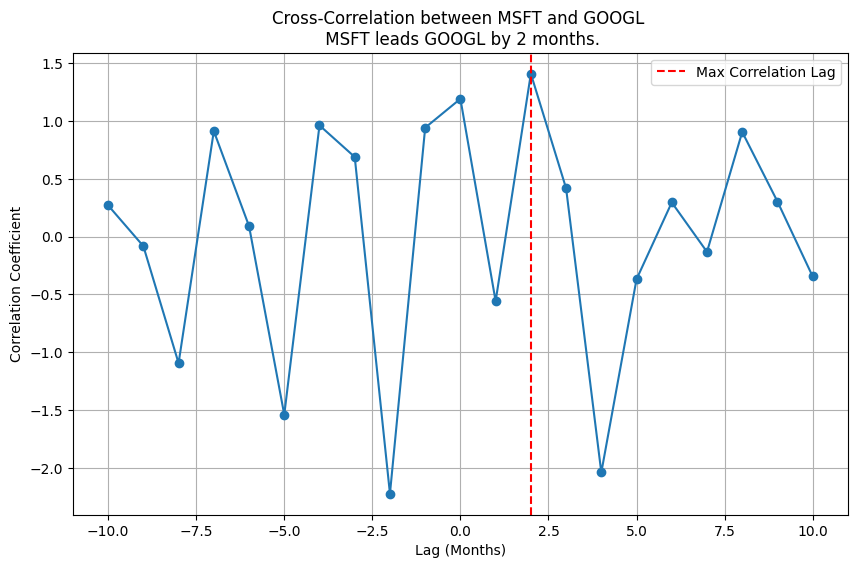

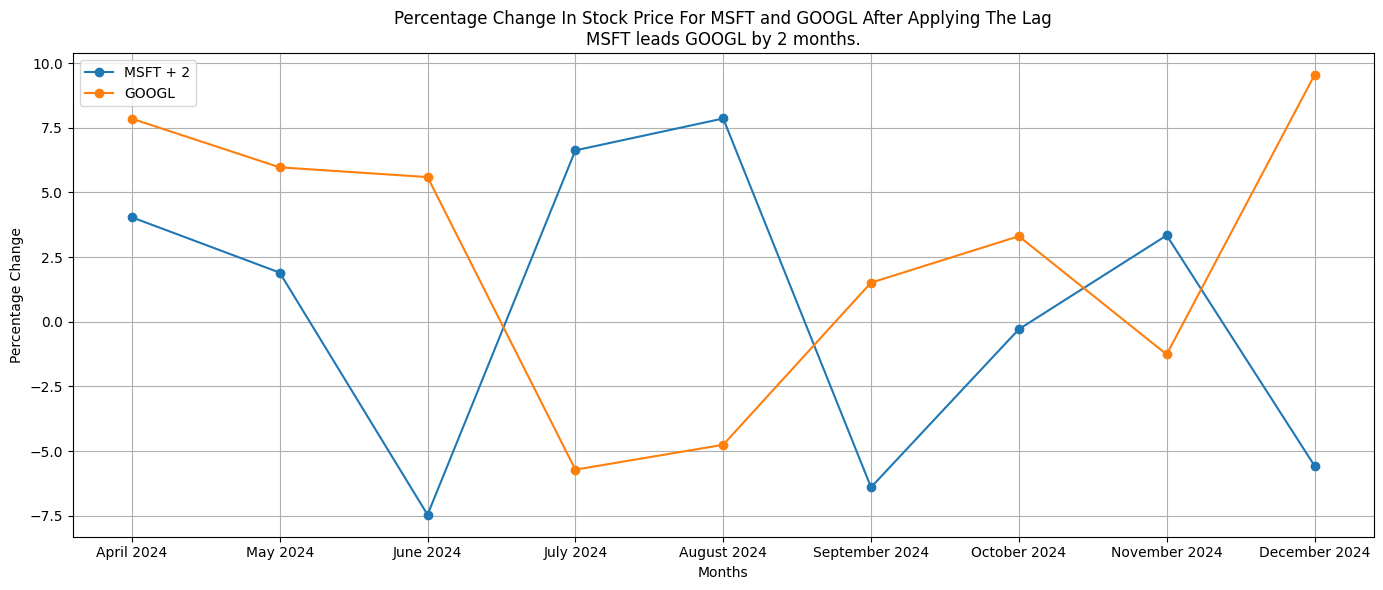

In [104]:
tag1 = "MSFT"
tag2 = "GOOGL"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

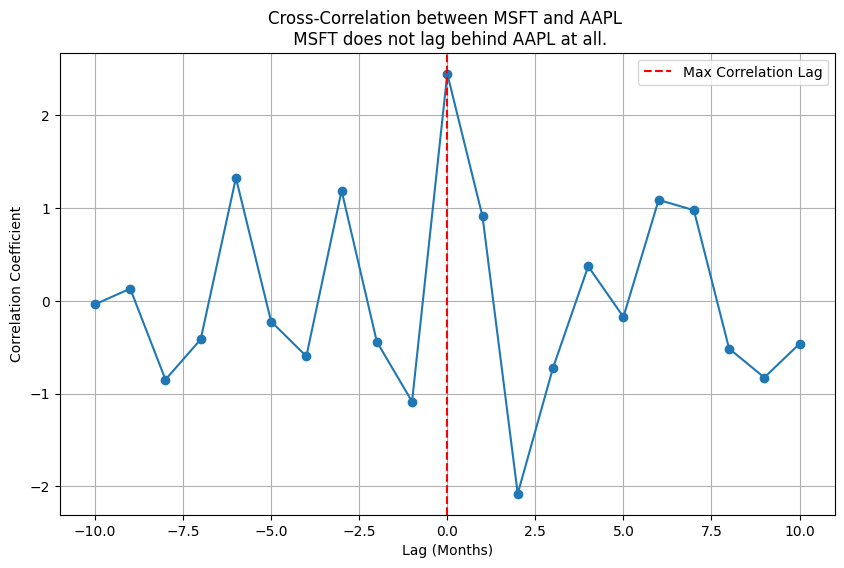

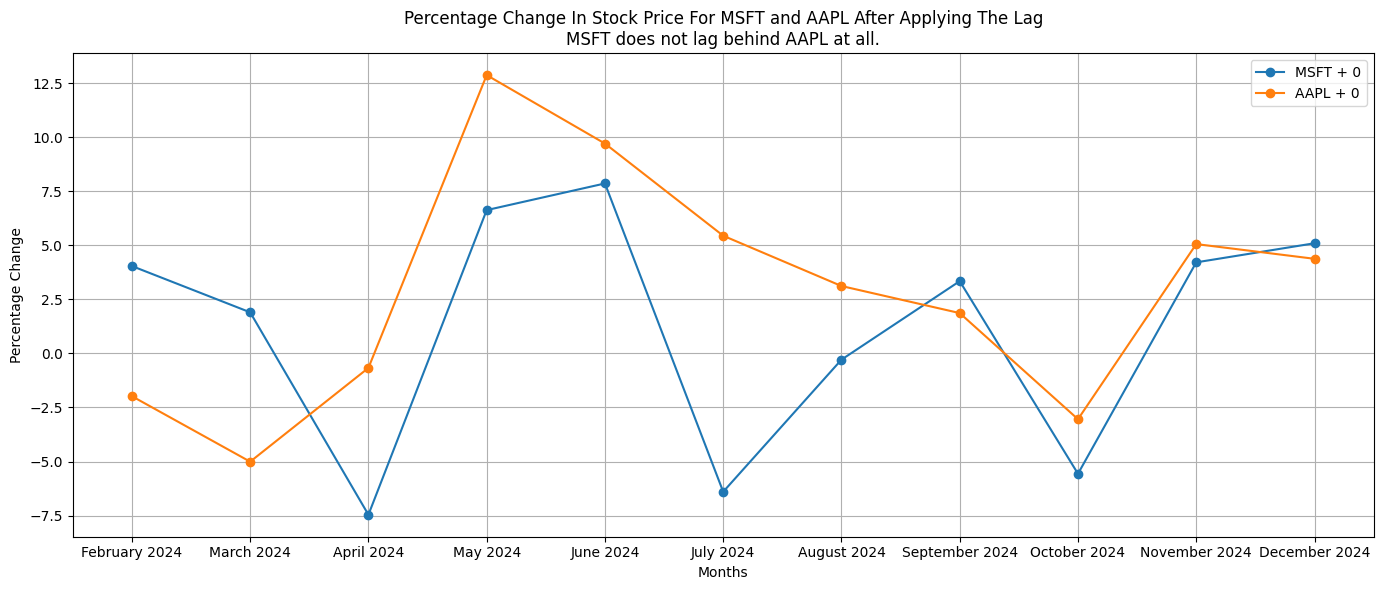

In [105]:
tag1 = "MSFT"
tag2 = "AAPL"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph)

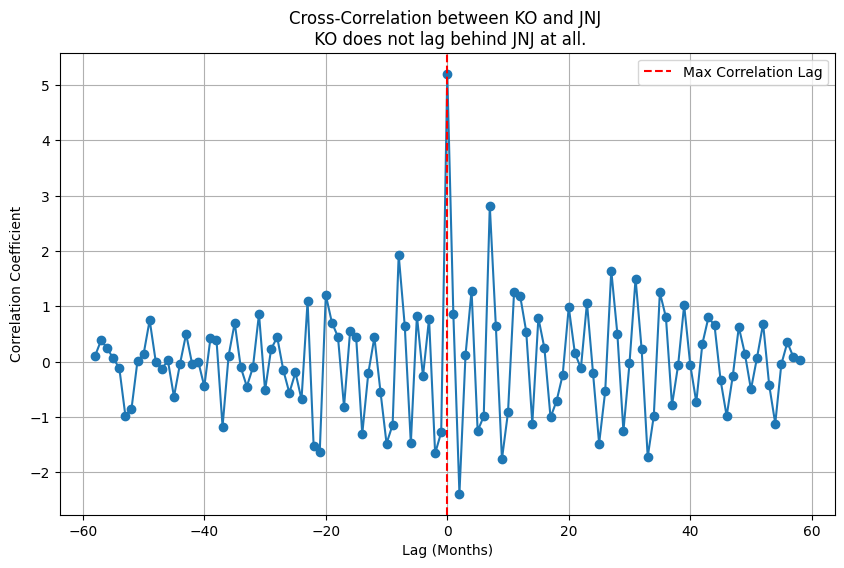

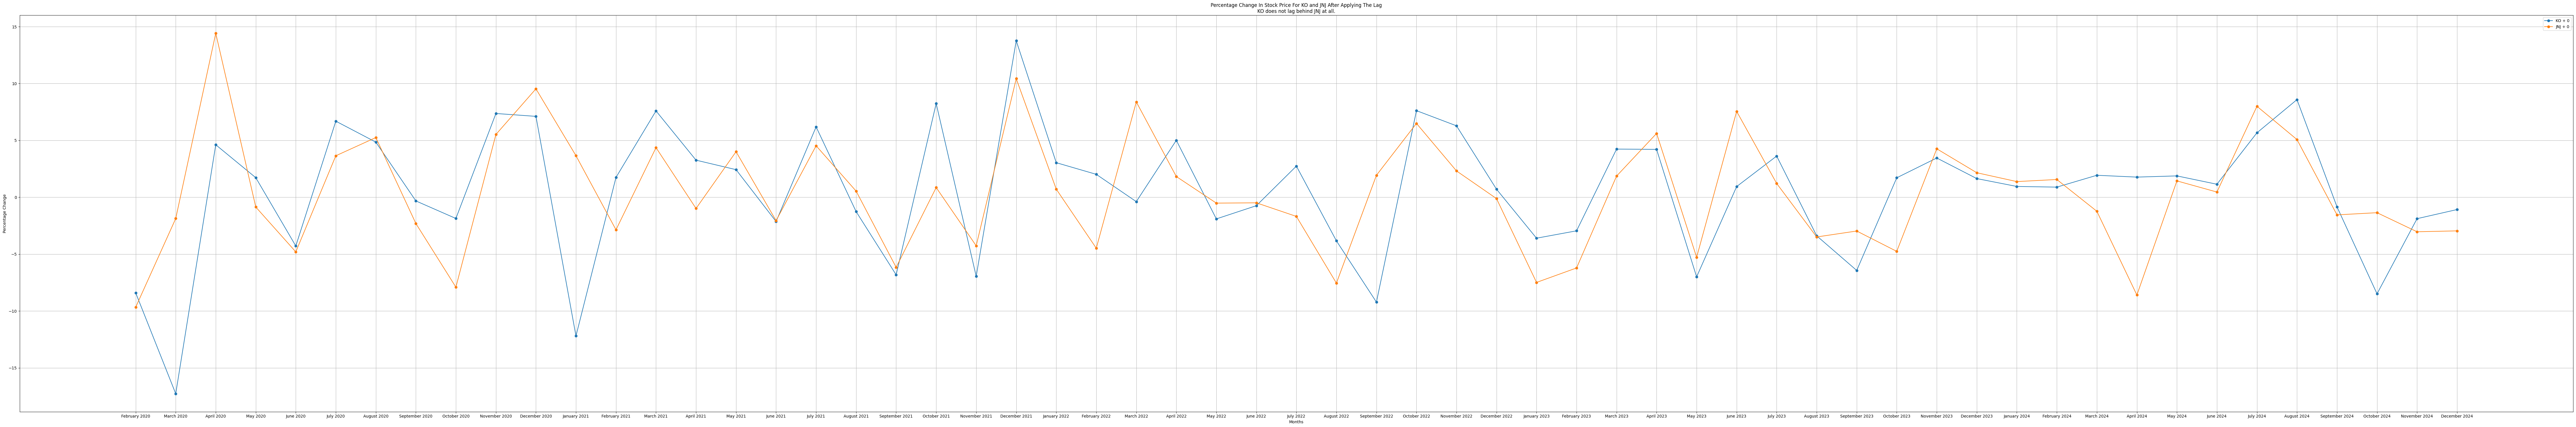

In [106]:
tag1 = "KO"
tag2 = "JNJ"
# displays the graph showing the correlation coeffiecient and the lag
displayLagGraph = True
# prints debug info
printInfo = False
# saves the computed data to the database
shouldSaveToDatabase = True
# Displays two stocks overlayed while accounting for lag
displayStockGraph = True
crossCorrelation(tag1,tag2,displayLagGraph,printInfo,shouldSaveToDatabase,displayStockGraph,"5y")